# Clustering task


## 1 Naive clustering

This is to establish a baseline, with well-selected features we hope to improve on it.

In [43]:
# imports and stuff
import numpy as np
import pandas
import scipy.misc as misc
from scipy import ndimage
from scipy import signal
import sklearn
from skimage.filters import gabor_kernel
import matplotlib.pyplot as plt
import cmath
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics

In [44]:
# read in the image
filename = 'san_sebastian.jpg'
img = misc.imread(filename)

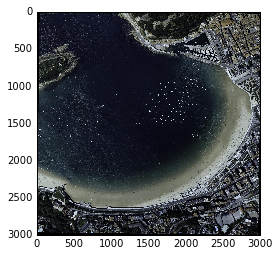

In [45]:
#take a look at the image
%matplotlib inline
plt.imshow(img)

## Some functions to convert RGB2Gray and vise versa

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[:,:,:3], [0.299, 0.587, 0.114])

def gray2rgb(gray):
    r = gray * 1/.299
    g = gray * 1/.587
    b = gray * 1/.114
    rgb = np.array([r,g,b])
    rgb = np.transpose(rgb,(1,2,0))
    return rgb

# 1.1 DBSCAN
Running DBSCAN on the image pixels without any intelligent features.

In [47]:
s_rate = 10 # sampling_rate
rows,cols,bands = img.shape
X = img[::s_rate,::s_rate].reshape((-1,3))
# Compute DBSCAN
db = DBSCAN(eps=3, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
dbscan_labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 34


## 1.1.1 Showing the clusters on the image 
For evaluation (visual and otherwise) we produce the prediction for each pixel in the image.

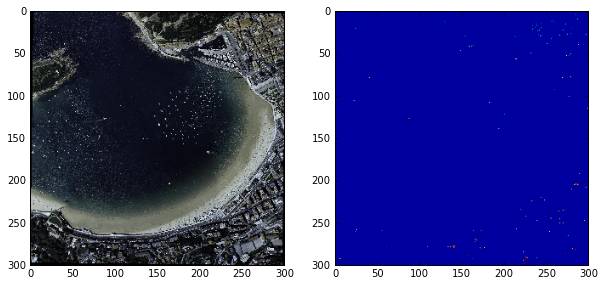

In [48]:
dbscan_labels = dbscan_labels.reshape((int(rows/s_rate),int(cols/s_rate)))
plt.figure(figsize = (10,20))
plt.subplot(1,2,1)
plt.imshow(img[::s_rate,::s_rate])
plt.subplot(1,2,2)
plt.imshow(dbscan_labels)

# 1.2 K-means

Running K-means on the image pixels without any help from features.

In [50]:
s_rate = 10 # sampling_rate
rows,cols,bands = img.shape
X = img[::s_rate,::s_rate].reshape((-1,3))
# Compute K-means
db = KMeans(init='k-means++',n_clusters=20,n_init=5).fit(X)
kmeans_labels = db.labels_

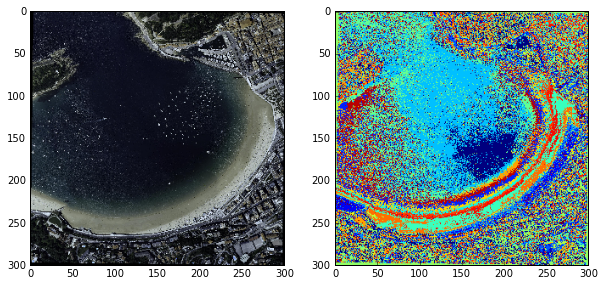

In [51]:
kmeans_labels = kmeans_labels.reshape((int(rows/s_rate),int(cols/s_rate)))
plt.figure(figsize = (10,20))
plt.subplot(1,2,1)
plt.imshow(img[::s_rate,::s_rate])
plt.subplot(1,2,2)
plt.imshow(kmeans_labels)

# 1.3 Mean shift

In [52]:
#TODO: implement

# 2. Clustering on selected features
In this part, we do some feature selection to improve on the naive approach.

## 2.1 Gabor kernels
A bank of Gabor kernels, with different orientations and frequencies.
In the first step it is going to be applied directly to the colors (RGB), later one can see if things would change if the gray level is used instead.

### 2.1.1 Design the filter bank 
I found some interesting info about some recommended banks, like this one
http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
here we start with simple stuff, later we can move on.

In [1]:
            kernels = []
#for theta in np.array([0,45,90,135])/180* np.pi:# different angles in the bank, 0 to 135°
            theta = .87
   #for sigma in [.5,1,3]:# sigma determines
            sigma = 1
    #    for frequency in (.5,1,3, 5): # the frequency of the sine wave in pixels
            frequency = 1
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)
            print('NO of kernels used %d' % len(kernels))
            
# Uncomment for the full bank
#kernels = []
#for theta in np.array([0,45,90,135])/180* np.pi:# different angles in the bank, 0 to 135°
#   for sigma in [.5,1,3]:# sigma determines
#    for frequency in (.5,1,3, 5): # the frequency of the sine wave in pixels
#            frequency = 1
#            kernel = np.real(gabor_kernel(frequency, theta=theta,
#                                          sigma_x=sigma, sigma_y=sigma))
#            kernels.append(kernel)
#print('NO of kernels used %d' % len(kernels))

NameError: name 'np' is not defined

### 2.1.2 Apply the filter and extract the features
This guy
http://stackoverflow.com/a/20610474
has got good results by using the following two features:<br\>
Local Energy = summing up the squared value of each matrix value from a response matrix<br\>
Mean Amplitude = sum of absolute values of each matrix value from a response matrix<br\>
other possibilites he mentioned are (Phase Amlitude and Orientation whose local has maximum Energy). these can be explored too, since we have the complex reponse of the filter already.

In [18]:
def extract_gabor_features(image, kernels,s_rate):
    bands = image.shape[2]
    filtered = []
    for k, kernel in enumerate(kernels):  
        for b in range(bands):
            img = signal.convolve2d(image[:,:,b], kernel, mode='same')
            sum_kernel = np.array([s_rate*[1]]*s_rate)
            energy_img = ndimage.convolve(img**2,sum_kernel)
            meanAmp_img = ndimage.convolve(np.abs(img),sum_kernel)
            # down sample both and add them to our feature vector
            filtered.append(energy_img[::s_rate,::s_rate]) 
            filtered.append(meanAmp_img[::s_rate,::s_rate]) 
    return filtered

In [ ]:
#reshape the features into an array suitable for passing to the clustering algorithm
feature_vec = extract_gabor_features(img,kernels,s_rate)
feature_arr = np.array(feature_vec)
feature_arr = feature_arr.transpose((1,2,0))

In [ ]:

print('Shape of the feature array %d X %d X %d' % feature_arr.shape)

### 2.1.3 Clustering of the features
Now apply the same clustering algorithms to the features, this way we can see the improvement brought in by the features (and we can compare them to other selection of features).

#### 2.1.3.1 DBSCAN

In [41]:
rows,cols,bands = feature_arr.shape
X = feature_arr.reshape((-1,bands))
# Compute DBSCAN
db = DBSCAN(eps=3, min_samples=3).fit(X)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

(90000, 6)
Estimated number of clusters: 614


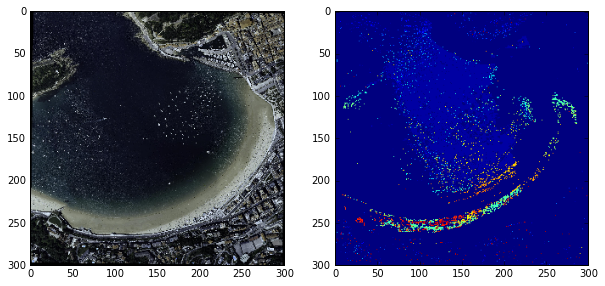

In [42]:
labels = labels.reshape((rows,cols))
plt.figure(figsize = (10,20))
plt.subplot(1,2,1)
plt.imshow(img[::s_rate,::s_rate])
plt.subplot(1,2,2)
plt.imshow(labels)

## 2.2 Evaluation
- Visual inspection
- Some metrics? ideas are welcome

## 2.3 Local variance
Calculate the local variance of each patch.
In addition, one can add the mean color of the patch (probably Gottfried's suggestion of the histogram is better, make the histogram of the patch and take the most frequent color).

## 2.4 More features?

In [1]:
# Any ideas are welcome

# 3. Image Search Engine
Simple search engine, find the 3 most similar to the query images in the database.
The database used is UC Merced set.
Using the feature extraction ideas developed above, one can find a descriptor for the query image, by comparing this descriptor to all images in the database (now using simple correlation) one can find the top matches.

In [22]:
# imports and stuff, probably duplicates of the above, but I am leaving it so one can start running from here onward
import numpy as np
import pandas
import scipy.misc as misc
from scipy import ndimage
from scipy import signal
import sklearn
from skimage.filters import gabor_kernel
import matplotlib.pyplot as plt
import cmath
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.filters import gabor_kernel
from skimage.feature import match_template

### Read in the images to a list.


In [15]:

img_dir='C:/Users/adam_fa/bse/small_sample'
from os import listdir
import scipy.misc as misc
from os.path import isfile, join,isdir
img_list = []
dir_list = [img_dir+'/'+ d for d in listdir(img_dir) if isdir(join(img_dir, d))]
print(dir_list)
for dir_name in dir_list:
    img_files = [dir_name+'/'+f for f in listdir(dir_name) if isfile(join(dir_name, f))]
    for filename in img_files:
        img_list.append(misc.imread(filename))
print(len(img_list),img_list[0].shape)

['C:/Users/adam_fa/bse/small_sample/all']
105 (256, 256, 3)


### Use a filter bank (like above)

In [16]:
kernels = []
theta = .87
sigma = 1
frequency = 2
kernel = np.real(gabor_kernel(frequency, theta=theta,
                              sigma_x=sigma, sigma_y=sigma))
kernels.append(kernel)
print('NO of kernels used %d' % len(kernels))
def make_kernels():
    kernels = []
    #for theta in np.array([0,45,90,135])/180* np.pi:# different angles in the bank, 0 to 135
    for theta in np.array([0,45,90])/180.* np.pi:# different angles in the bank, 0 to 135
    #   for sigma in [.5,1,3]:# sigma determines
       for sigma in [1,2]:# sigma determines
    #    for frequency in (.5,1,3, 5): # the frequency of the sine wave in pixels
         for frequency in (1,3): # the frequency of the sine wave in pixels
                frequency = 1
                kernel = np.real(gabor_kernel(frequency, theta=theta,
                                              sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    print('NO of kernels used %d' % len(kernels))
    return kernels

NO of kernels used 1


### Pick the query image

In [46]:
query_no = 0
s_rate = 8
kernels = make_kernels()
query = img_list[query_no]
query_features = extract_gabor_features(query,kernels,s_rate)
query_img = np.array(query_features).reshape((-1,1))

NO of kernels used 12


 ### loop through all images in the database and extrace the features then calculate the correlation

In [47]:
data = []
for i,rgb_img in enumerate(img_list):
        rgb_img = img_list[i]
        if i%10 == 0:
            print('Did %d' % i)
        img_features_vec = extract_gabor_features(rgb_img,kernels,s_rate)
        img_features_arr = np.array(img_features_vec).reshape((-1,1))
        test_img = img_features_arr
        result = match_template(query_img,test_img)
        data.append(np.asarray(result).max())
print('Did %d' % (i+1))

Did 0
Did 10
Did 20
Did 30
Did 40
Did 50
Did 60
Did 70
Did 80
Did 90
Did 100
Did 104


In [48]:
    data[query_no] = 0
    match1 = img_list[np.argmax(data)]
    print('First match is img no %d' % (np.argmax(data)))
    print('Correlation %f' % max(data))
    data[np.argmax(data)] = 0
    match2 = img_list[np.argmax(data)]
    print('Second match is img no %d'  % (np.argmax(data)))
    print('Correlation %f' % max(data))
    data[np.argmax(data)] = 0
    match3 = img_list[np.argmax(data)]
    print('Thrid match is img no %d' % (np.argmax(data)))
    print('Correlation %f' % max(data))

First match is img no 1
Correlation 0.960881
Second match is img no 3
Correlation 0.958626
Thrid match is img no 2
Correlation 0.953005


### Here is the query image

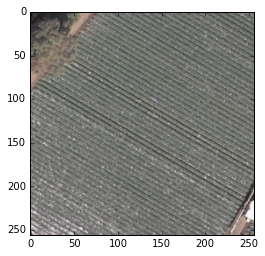

In [49]:
%matplotlib inline
plt.imshow(query)
plt.show()

### And the 3 most similar images in the database

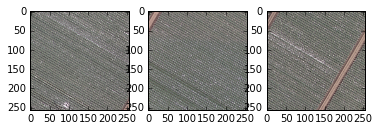

In [50]:
    plt.subplot(1,3,1)
    plt.imshow(match1)
    plt.subplot(1,3,2)
    plt.imshow(match2)
    plt.subplot(1,3,3)
    plt.imshow(match3)
    plt.show()